<a href="https://colab.research.google.com/github/Cry069/Computer-Vision-/blob/main/Data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dansbecker_cityscapes_image_pairs_path = kagglehub.dataset_download('dansbecker/cityscapes-image-pairs')

print('Data source import complete.')


In [ ]:
import os
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torch.amp import autocast, GradScaler # Sneaky capital S in GradScaler
import torchvision.transforms.functional as TF
from torchvision import tv_tensors

In [ ]:
# Standard Cityscapes mapping: Raw ID -> Train ID
# 255 will be ignored by nn.CrossEntropyLoss(ignore_index=255)
mapping = {
    7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8,
    22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
}

lookup = np.ones(256, dtype=np.int64) * 255
for raw_id, train_id in mapping.items():
    lookup[raw_id] = train_id

In [ ]:
# The official colors for the 19 training classes
# The 20th color (index 19) is for the 'void/ignore' class (usually black)
CITYSCAPES_COLORS = [
    [128, 64, 128],  # 0: road
    [244, 35, 232],  # 1: sidewalk
    [70, 70, 70],    # 2: building
    [102, 102, 156], # 3: wall
    [190, 153, 153], # 4: fence
    [153, 153, 153], # 5: pole
    [250, 170, 30],  # 6: traffic light
    [220, 220, 0],   # 7: traffic sign
    [107, 142, 35],  # 8: vegetation
    [152, 251, 152], # 9: terrain
    [70, 130, 180],  # 10: sky
    [220, 20, 60],   # 11: person
    [255, 0, 0],     # 12: rider
    [0, 0, 142],     # 13: car
    [0, 0, 70],      # 14: truck
    [0, 60, 100],    # 15: bus
    [0, 80, 100],    # 16: train
    [0, 0, 230],     # 17: motorcycle
    [119, 11, 32],   # 18: bicycle
    [0, 0, 0]        # 19/255: void/background
]

In [ ]:
class Cityscape(Dataset):
    def __init__(self, imgs_path, masks_path, transform_mode):
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.transform_mode = transform_mode

        self.image_file = sorted(os.listdir(self.imgs_path))
        self.mask_file = sorted(os.listdir(self.masks_path))

    def __len__(self):
        return len(self.image_file)

    def split_image(self, img):
        img = np.array(img)
        mid = img.shape[1] // 2  # Fixed: changed 'image' to 'img'
        cityscape, label = img[:, :mid, :], img[:, mid:, :]
        return Image.fromarray(cityscape), Image.fromarray(label)

    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_path, self.image_file[idx])
        combined = Image.open(img_path).convert('RGB')

        image, mask = self.split_image(combined)
        mask = mask.convert("L") # Ensure mask is grayscale

        mask_np = np.array(mask)
        mask_mapped = lookup[mask_np].astype(np.uint8)  # Fixed: lowercase 'lookup'
        mask = Image.fromarray(mask_mapped)

        # Apply transforms separately
        if self.transform_mode.upper() == 'TRAIN':
            image = train_transform(image)
            mask = train_mask_transform(mask)  # Need separate mask transform
        else:
            image = test_transform(image)
            mask = test_mask_transform(mask)   # Need separate mask transform

        mask = mask.squeeze().long()

        return image, mask

In [ ]:
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.4, contrast=0.2),
    T.ToImage(),
    T.ToDtype(torch.float, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToImage(),
    T.ToDtype(torch.float, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.ToImage(),
    T.ToDtype(torch.uint8, scale=False)  # ✅ SAFE
])

test_mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.ToImage(),
    T.ToDtype(torch.uint8, scale=False)  # ✅ SAFE
])


In [ ]:
train_combined_path = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train'
val_combined_path = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val'

train_ds = Cityscape(train_combined_path, train_combined_path, transform_mode='TRAIN')
val_ds = Cityscape(val_combined_path, val_combined_path, transform_mode='TEST')


train_loader = DataLoader(train_ds,
                      batch_size=8,
                      shuffle=True,
                      drop_last=True,
                      num_workers=0,
                      pin_memory=True)

val_loader = DataLoader(val_ds,
                     batch_size=8,
                     shuffle=False,
                     drop_last=False,
                     num_workers=0,
                     pin_memory=True)

In [ ]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=19, features=[64, 128, 256, 512]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Downsampling)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder (Upsampling)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        # Final convolution for 19 classes
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoder
        skip_connections = skip_connections[::-1]

        # Decoder
        for idx in range(0, len(self.ups), 2):
            # Upsample
            x = self.ups[idx](x)

            # Get corresponding skip connection
            skip_connection = skip_connections[idx//2]

            # Resize if shapes don't match (for odd input dimensions)
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:],
                                 mode='bilinear', align_corners=True)

            # Concatenate and pass through DoubleConv
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

[ 403707  548265  238387  168548  225970 2667514  760158  366610  257041
  202051  338839  143707  129024  295420  141692  115680  125084  188175
 1406884]


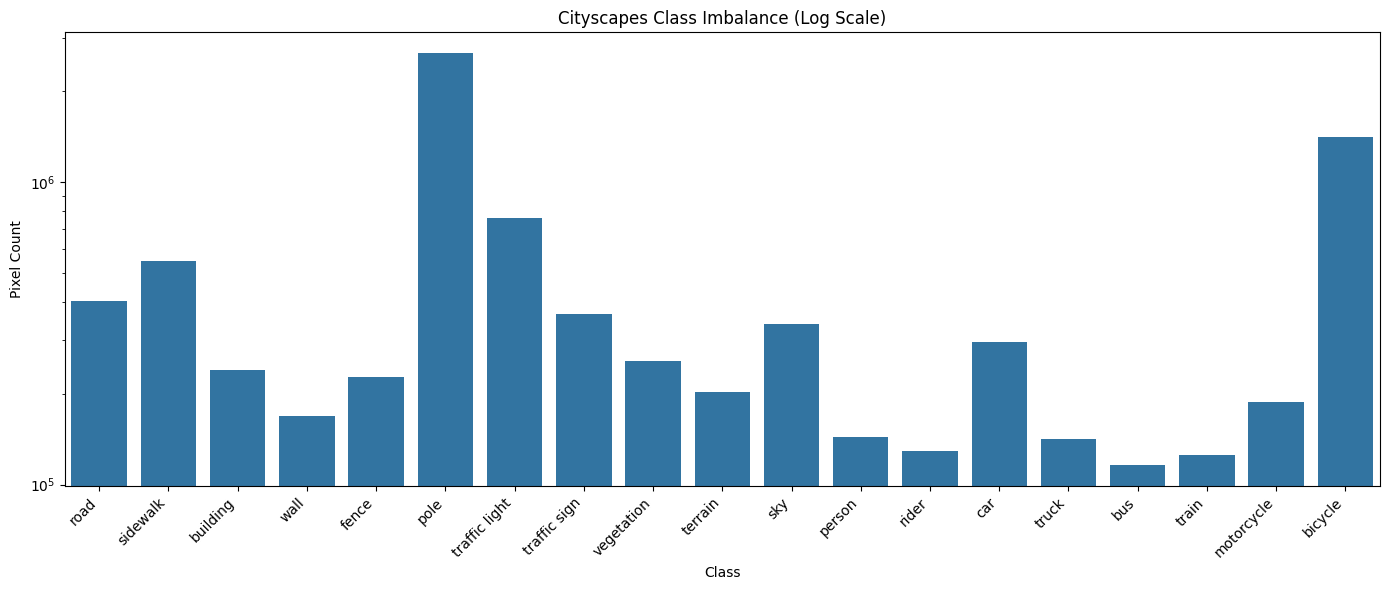

In [ ]:
import torch

num_classes = 19
ignore_index = 255

class_counts = torch.zeros(num_classes, dtype=torch.long)

for _, masks in train_loader:
    masks = masks.view(-1)
    for c in range(num_classes):
        class_counts[c] += (masks == c).sum()

class_counts = class_counts.cpu().numpy()
print(class_counts)
import pandas as pd

class_names = [
    "road","sidewalk","building","wall","fence","pole","traffic light",
    "traffic sign","vegetation","terrain","sky","person","rider","car",
    "truck","bus","train","motorcycle","bicycle"
]

df = pd.DataFrame({
    "Class": class_names,
    "Pixel Count": class_counts
})
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.barplot(data=df, x="Class", y="Pixel Count")
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Cityscapes Class Imbalance (Log Scale)")
plt.tight_layout()
plt.show()


In [ ]:


num_classes = 19

# class_counts: numpy array or torch tensor of size [19]
class_counts_tensor = torch.tensor(class_counts, dtype=torch.float32)

# Inverse frequency
weights = 1.0 / (class_counts_tensor + 1e-6)

# Normalize weights (important for stability)
weights = weights / weights.sum() * num_classes

weights = weights.to(device)

print("Class weights:")
print(weights)


Class weights:
tensor([0.5679, 0.4181, 0.9617, 1.3601, 1.0145, 0.0859, 0.3016, 0.6253, 0.8919,
        1.1346, 0.6766, 1.5953, 1.7768, 0.7760, 1.6179, 1.9818, 1.8328, 1.2183,
        0.1629], device='cuda:0')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET().to(device)
criterion = nn.CrossEntropyLoss(weight = weights,ignore_index=255)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)
scaler = GradScaler(enabled=(device.type == "cuda"))

In [ ]:
def compute_iou(preds, masks, num_classes=19, ignore_index=255):
    """Compute Mean IoU for 19 classes, ignoring void pixels"""
    ious = []
    # Convert probabilities/logits to class predictions
    preds = torch.argmax(preds, dim=1)

    # Flatten tensors for easier calculation
    preds = preds.view(-1)
    masks = masks.view(-1)

    # Filter out ignore_index (255)
    valid_mask = (masks != ignore_index)
    preds = preds[valid_mask]
    masks = masks[valid_mask]

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        mask_cls = (masks == cls)

        intersection = (pred_cls & mask_cls).sum().float()
        union = (pred_cls | mask_cls).sum().float()

        if union > 0:
            ious.append((intersection / union).item())
        # If union is 0, the class isn't in this batch, so we skip it

    return np.nanmean(ious) if len(ious) > 0 else 0.0

In [ ]:
import numpy as np
from tqdm.auto import tqdm
EPOCHS = 50

print(f"Starting Training for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    model.train()

    epoch_loss = 0
    epoch_iou = 0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=(device.type == "cuda")):

            outputs = model(images)
            loss = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            batch_iou = compute_iou(outputs, masks, num_classes=num_classes)

        epoch_loss += loss.item()
        epoch_iou += batch_iou

    current_loss = epoch_loss / len(train_loader)
    current_iou = epoch_iou / len(train_loader)

    print(
        f"--- Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {current_loss:.4f} | "
        f"mIoU: {current_iou:.4f} ---"
    )


Starting Training for 50 Epochs...
--- Epoch 1/50 | Loss: 2.8221 | mIoU: 0.0705 ---
--- Epoch 2/50 | Loss: 2.7198 | mIoU: 0.0879 ---
--- Epoch 3/50 | Loss: 2.6149 | mIoU: 0.1095 ---
--- Epoch 4/50 | Loss: 2.5261 | mIoU: 0.1277 ---
--- Epoch 5/50 | Loss: 2.4553 | mIoU: 0.1417 ---
--- Epoch 6/50 | Loss: 2.3950 | mIoU: 0.1570 ---
--- Epoch 7/50 | Loss: 2.3367 | mIoU: 0.1745 ---
--- Epoch 8/50 | Loss: 2.2872 | mIoU: 0.1890 ---
--- Epoch 9/50 | Loss: 2.2522 | mIoU: 0.1999 ---
--- Epoch 10/50 | Loss: 2.2285 | mIoU: 0.2062 ---
--- Epoch 11/50 | Loss: 2.2079 | mIoU: 0.2107 ---
--- Epoch 12/50 | Loss: 2.1928 | mIoU: 0.2143 ---
--- Epoch 13/50 | Loss: 2.1736 | mIoU: 0.2183 ---
--- Epoch 14/50 | Loss: 2.1606 | mIoU: 0.2201 ---
